# Análisis de acciones de empresas ecuatorianas 
### Un repaso a la década 2010-2019

**Autor:   Juan José Triviño Zambrano**  
**Fecha:   Mayo 30, 2021**

Hace exactamente un año ya, de la publicación de mi estudio [Valoración de títulos de renta fija](https://nbviewer.jupyter.org/github/juanjosetz/financial/blob/master/valoracion_titulos.ipynb). Para esta ocasión he creido conveniente hacer en cambio un estudio de renta variable, más especificamente de acciones. Esta vez, no desde la perspectiva de valoración de títulos como se lo hizo en el estudio antes mencionado, sino desde la perspectiva del análisis de los rendimientos históricos que arrojaron las acciones más populares de la década pasada. Para esto haremos uso de ciertos conceptos estadísticos, financieros y bursátiles; todo esto apoyado nuevamente, como no, de nuestra querida "navaja suiza" **Python** con sus estupendas librerías para el manejo, análisis y visualización de datos.

## Fuente de la información
### Bolsa de Valores de Guayaquil

La Bolsa de Valores de Guayaquil a través de su [sitio web](https://www.bolsadevaloresguayaquil.com/valoracion/index.asp), en el apartado de valoración, publica información referente a títulos de renta fija y renta variable. No es la mejor forma de presentar la información (a través de hojas de cálculo), algo que denota la falta de técnica en la publicación de la información. Hay que decir que esto lo viene realizando desde el año 2007 sin que en todos estos años, hayan innovado o mejorado la forma de proporcionar la información a sus usuarios/clientes, cuando hoy en día existen fabulosas herramientas basadas en web, para trabajar con tablas de datos e inclusive bases de datos relacionales. Aún así, "es lo que hay" y se le puede sacar provecho de alguna manera.

La información viene presentada en dos vertientes:
1. **Diaria:** Que regoge la información diaria de los títulos, la cual solo está disponible en su último día, actualizándose cada dia laborable.
2. **Histórica:** Que recoge la información con periodicidad mensual, para lo cual existe un directorio para todo su historial desde el año 2007.

## Metodología del análisis

El rendimiento de una acción es determinado por dos factores:

1. Revalorización del precio de la acción
2. Dividendos recibidos

En este sentido, seleccionaremos las 10 compañias más representativas en bolsa la década pasada y evaluaremos todas las ganancias de capital y dividendos recibidos a través del período de análisis. Esto no supone mayor difcultad, lo retador es, estructurar todos los datos desde la fuente, dada la rusticidad y desorganización de la información que se presenta.

## Obtención y preparación de datos

### Descarga de los archivos desde el directorio web
Lo que necesitamos ahora es toda la data histórica para después agrupar y consolidar la información a través del tiempo y poder construir una suerte de datos de panel. Para esto tenemos que descargar todos estos reportes mensuales contenidos en los archivos *xls*. Aparentemente estos ficheros solo están disponibles para el año actual y el anterior, pues así se muestra en su pestaña `Histórico`. Los demás ficheros de años anteriores si se encuentran disponibles pero permanecen ocultos de la interfaz web. Para tener acceso a ellos debemos primero ingresar al [directorio](https://www.bolsadevaloresguayaquil.com/valoracion/Historico/) donde están alojados todos estos ficheros. Una vez dentro, ya podemos descargar todos los ficheros y así lo haremos, pero no de la forma ortodoxa de ir descargando uno por uno los archivos, sino que diseñaremos una función para que haga el trabajo por nosotros.
Además de descargarlos, la diseñaremos para que le dé un nombre más adecuado a los archivos `(aa-mm-dd)`, esto para que estén mejor ordenados con un formato estándar de patrón de fecha, algo que nos servirá para asociar cada reporte de precios a una fecha en concreto.

In [1]:
from bs4 import BeautifulSoup
import requests
import re

In [2]:
def descargar_archivos():
    url = "https://www.bolsadevaloresguayaquil.com/valoracion/Historico/"
    codigo_html = requests.get(url).text
    web = BeautifulSoup(codigo_html, "lxml")
    links = web.find_all('a')
    url_links = [url[:39] + links[href].get('href') for href in range(1,len(links))]
    meses = {'Enero':'01', 'Febrero':'02', 'Marzo':'03', 'Abril':'04', 'Mayo':'05', 'Junio':'06',
             'Julio':'07', 'Agosto':'08', 'Septiembre':'09', 'Octubre':'10', 'Noviembre':'11', 'Diciembre':'12'}
    
    for url in url_links:
        idx = url.rfind('/')
        nombre_ini = url[idx+1:]
        lista = re.findall('\d+|\D+', nombre_ini)
        
        if len(lista) == 4:
            nombre_fin = f'{lista[2]}-{meses[lista[1]]}-{lista[0]}{lista[3]}'
            resp = requests.get(url)
            
            with open(nombre_fin, 'wb') as output:
                output.write(resp.content)

## Operaciones con los ficheros descargados

### Extrayendo la data de los archivos

>Uno de los problemas (de los tantos) de las hojas de cálculo, es que la información suele venir 'desorganizada y sucia'. No hay problema, diseñaremos un programa que nos permita extraer la data relevante para nuestro análisis, descartando la información que no vayamos a utilizar.

El algoritmo siguiente extrae los datos relevantes para este análisis de cada uno de los ficheros descargados y los guarda en el objeto `data`:

In [3]:
import os
import numpy as np
import pandas as pd
from datetime import datetime

In [4]:
directorio = "archivos/"
data = []

for filename in os.listdir(directorio):
    fecha = filename[:8]
    campos = ['Unnamed: 0', '# RUEDAS', "PRESENCIA", "# RUEDAS.1", "PRESENCIA.1", "CIERRE NACIONAL"]
    df = pd.read_excel(directorio + filename, 'Precios-Renta Variable', skiprows=8, index_col=0, usecols=campos)
    df.dropna(inplace=True)
    df['CIERRE NACIONAL'].replace('*', np.nan, inplace=True)
    df['FECHA'] = pd.to_datetime(fecha, format='%y-%m-%d', errors='ignore')
    data.append(df)
    
cias = df.index

### Consolidando toda la información en un `DataFrame`

Una vez con todos los datos agrupados, necesitamos consolidar la información que hay en ella (contiene datos de la Bolsa de Valores de Guayaquil y de la Bolsa de Valores de Quito). Para ello se implementa el siguiente algoritmo:

In [5]:
consolidado = pd.concat(data)
consolidado = consolidado.astype({'# RUEDAS': int, "PRESENCIA": float, "# RUEDAS.1": int })
nombre_columnas = ['RUEDAS.UIO', 'PRESENCIA.UIO', 'RUEDAS.GYE', 'PRESENCIA.GYE', 'PRECIO', 'FECHA']
consolidado.columns = nombre_columnas
consolidado['PRESENCIA'] = (consolidado['PRESENCIA.UIO']+consolidado['PRESENCIA.GYE'])/2

La información consolidada se presenta en la siguiente tabla, donde los datos que utilizaremos posteriormente son:
* **Precios** (Cierre Nacional) y;
* **Presencia Bursátil**, que en este caso se ha recogido el promedio entre las dos bolsas Quito y Guayaquil

In [6]:
consolidado

,RUEDAS.UIO,PRESENCIA.UIO,RUEDAS.GYE,PRESENCIA.GYE,PRECIO,FECHA,PRESENCIA
AGRICOLA INDUSTRIAL TROPICAL,0,0.000000,0,0.000000,NaN,2007-01-31,0.000000
BANCO AMAZONAS,0,0.000000,0,0.000000,NaN,2007-01-31,0.000000
BANCO BOLIVARIANO,1,0.016667,7,0.114754,1.10,2007-01-31,0.065710
BANCO DE GUAYAQUIL,59,0.983333,60,0.983607,3.20,2007-01-31,0.983470
BANCO SOLIDARIO,10,0.166667,2,0.032787,0.95,2007-01-31,0.099727
...,...,...,...,...,...,...,...
SOCIEDAD AGRICOLA E IND. SAN CARLOS,0,0.000000,5,0.081967,0.60,2021-03-31,0.040984
SUPERDEPORTE,0,0.000000,1,0.016393,6.05,2021-03-31,0.008197
SURPAPELCORP,0,0.000000,0,0.000000,NaN,2021-03-31,0.000000
TECATEAK S.A.,0,0.000000,0,0.000000,NaN,2021-03-31,0.000000


## Precios

Del consolidado anterior pivoteamos la tabla para crear una nueva tabla solamente de precios. Esta tabla nos servirá de base para ubicar los precios a través del tiempo.

>**Observación:** La periodicidad de los datos es mensual, de tal manera que puede existir alguna imprecisión de los valores para una determinada fecha que no coincida con el corte de fin de mes.

In [7]:
precios = pd.pivot_table(consolidado, index='FECHA', columns = consolidado.index, values='PRECIO')
precios.ffill(inplace=True)
precios = precios[set(cias) & set(precios.columns)]
precios

,CORPORACION MULTI BG,BANCO BOLIVARIANO,VALLE GRANDE FORESTAL,NATLUK S.A.,INGENIO AZUCARERO DEL NORTE COMPAÑIA DE ECONOMIA MIXTA IANCEM,ALICOSTA BK HOLDING,EL SENDERO FORESTAL PATHFOREST,BANCO PICHINCHA,CERRO VERDE FORESTAL BIGFOREST,LA CAMPIÑA FORESTAL STRONGFOREST S.A.,...,CEPSA,RIO CONGO FORESTAL,BOLSA DE VALORES DE QUITO BVQ SOCIEDAD ANÓNIMA,SIEMPREVERDE S.A.,CERRO ALTO FORESTAL,CERVECERIA NACIONAL CN S.A.,BEVERAGE BRAND & PATENTS COMPANY BBPC S.A,HOTEL COLON,CIALCO,EL REFUGIO FORESTAL HOMEFOREST
FECHA,,,,,,,,,,,,,,,,,,,,,
2007-01-31,NaN,1.10,NaN,NaN,NaN,NaN,NaN,NaN,13.00,NaN,...,NaN,20.0,NaN,NaN,NaN,NaN,NaN,0.56,4.17,NaN
2007-02-28,NaN,1.50,NaN,NaN,NaN,NaN,NaN,NaN,13.00,NaN,...,NaN,20.0,NaN,NaN,NaN,NaN,NaN,0.70,4.17,NaN
2007-03-30,NaN,1.50,NaN,NaN,NaN,NaN,NaN,NaN,13.00,NaN,...,NaN,20.0,NaN,NaN,NaN,NaN,NaN,0.70,4.17,NaN
2007-04-30,NaN,1.55,NaN,NaN,NaN,NaN,NaN,NaN,12.75,NaN,...,NaN,20.0,NaN,NaN,NaN,NaN,NaN,0.70,4.17,NaN
2007-05-31,NaN,1.55,NaN,NaN,NaN,NaN,NaN,NaN,13.75,NaN,...,NaN,20.0,NaN,NaN,NaN,NaN,NaN,0.70,4.17,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-30,8.62,0.90,2.82,7.00,2.2,10.0,23.0,86.0,33.50,31.5,...,1.0,40.0,1.08,NaN,15.75,85.00,87.0,0.65,1.80,27.00
2020-12-30,8.62,0.90,2.82,6.75,2.2,10.0,23.0,100.0,31.91,31.5,...,1.0,40.0,1.16,NaN,15.75,84.00,87.0,0.65,1.80,27.00
2021-01-29,8.62,0.90,2.82,6.75,2.2,10.0,23.0,100.0,31.91,31.5,...,1.0,40.0,1.10,1.7,15.05,85.00,87.0,0.65,1.80,25.68


## Presencia bursátil

Indica el grado de liquidez de la acción. Se lo calcula dividiendo el número de ruedas (sesiones de negociación) en que la acción ha sido transada en el último semestre móvil para el número de ruedas realizadas en total durante el mismo semestre móvil.

> Este indicador nos será util para conocer cuales son las acciones que más se tranzan en la bolsa de valores y poder conformar nuestro portafolio de análisis posteriormente.

El siguiente programa generará la tabla de presencia bursátil que necesitamos, en el cual aplicaremos algunos filtros necesarios:

In [8]:
presencia = pd.pivot_table(consolidado, index='FECHA', columns = consolidado.index, values='PRESENCIA')
presencia = presencia[precios.columns]
ranking_presencia = presencia.mean().sort_values(ascending=False)

pd.DataFrame(ranking_presencia, columns=["PRESENCIA BURSATIL"]).head(20).style.format("{:.0%}").set_table_styles(
        [dict(selector='th', props=[('text-align', 'left')])] )

,PRESENCIA BURSATIL
CORPORACION FAVORITA,79%
BANCO GUAYAQUIL,28%
BRIKAPITAL,22%
MUTUALISTA PICHINCHA - CERT. DE APORTACION,19%
BANCO PICHINCHA,15%
FIDEICOMISO HOTEL CIUDAD DEL RIO,14%
NATLUK S.A.,14%
HOLCIM ECUADOR VN 3.00,12%
SOCIEDAD AGRICOLA E IND. SAN CARLOS,12%
LA ENSENADA FORESTAL S.A.,11%


## Dividendos

Habíamos dicho que además de la revalorización del precio de la acción, la otra forma de obtener ganancias con las acciones es mediante los dividendos. El *precio* ya lo tenemos en un `DataFrame` de precios, proveniente de los archivos en excel que descargamos inicialmente, de donde también se obtuvo la tabla de *Presencia Bursátil*.

Para obtener la información referente al reparto de dividendos, es necesario extraer los datos desde otro apartado web, que es el de [Dividendos Entregados](https://www.bolsadevaloresguayaquil.com/dividendos/). En esta página obtendremos además información referente al aumento de capital (capitalización de acciones) y de aumento/disminución de acciones, con lo cual saber si se ha ejecutado un split en algún momento.

Con el siguiente código se extrae la información contenida en esa página web, además de limpiar y formatear los datos para poder utilizarlos posteriormente.

In [9]:
url = "https://www.bolsadevaloresguayaquil.com/dividendos/"

list_div = pd.read_html(url)
div = pd.concat(list_div)

meses = {'Ene':'01', 'Feb':'02', 'Mar':'03', 'Abr':'04', 'May':'05', 'Jun':'06',
             'Jul':'07', 'Ago':'08', 'Sep':'09', 'Oct':'10', 'Nov':'11', 'Dic':'12'}

div['#ACCIONES ANTESDEL EVENTO'].fillna(method='ffill', inplace=True) #Hay un valor perdido en este campo
div['FECHA'] = div['FECHA'].apply(lambda x: x.replace(x[3:6], meses[x[3:6]]))
div['FECHA'] = pd.to_datetime(div['FECHA'], format='%d/%m/%Y')
div['EMISOR'].ffill(inplace=True)
div['BPA'] = div['DIVIDENDO EFECTIVOTOTAL'] / div['#ACCIONES ANTESDEL EVENTO']
div['BPA'].fillna(0, inplace=True)

pivot_div = pd.pivot_table(div, index=['EMISOR', 'FECHA'])
pivot_div = pivot_div.astype({'#ACCIONES ANTESDEL EVENTO': 'int', '#ACCIONES DESPUÉSDEL EVENTO': 'int'})
pivot_div 

#ACCIONES ANTESDEL EVENTO  \
EMISOR                                     FECHA                                   
ALICOSTA  BK HOLDING S.A.                  2014-03-25                     235000   
                                           2015-03-31                     235000   
                                           2016-03-29                     235000   
                                           2017-03-28                     235000   
                                           2018-03-28                     235000   
...                                                                          ...   
SURPAPELCORP  S.A.                         2017-04-05                   25677000   
                                           2017-06-08                   50128485   
                                           2018-06-08                   50128485   
VALLE  GRANDE FORESTAL (VALLEYFOREST) S.A. 2019-03-26                    1700000   
                                           2020-07-17                    1700000   

                                                       #ACCIONES DESPUÉSDEL EVENTO  \
EMISOR                                     FECHA                                     
ALICOSTA  BK HOLDING S.A.                  2014-03-25                       235000   
                                           2015-03-31                       235000   
                                           2016-03-29                       235000   
                                           2017-03-28                       235000   
                                           2018-03-28                       235000   
...                                                                            ...   
SURPAPELCORP  S.A.                         2017-04-05                     25677000   
                                           2017-06-08                     50128485   
                                           2018-06-08                     50128485   
VALLE  GRANDE FORESTAL (VALLEYFOREST) S.A. 2019-03-26                      1700000   
                                           2020-07-17                      1700000   

                                                       % DIVIDENDO ACCIÓN  \
EMISOR                                     FECHA                            
ALICOSTA  BK HOLDING S.A.                  2014-03-25                 NaN   
                                           2015-03-31                 NaN   
                                           2016-03-29                 NaN   
                                           2017-03-28                 NaN   
                                           2018-03-28                 NaN   
...                                                                   ...   
SURPAPELCORP  S.A.                         2017-04-05                 NaN   
                                           2017-06-08                 NaN   
                                           2018-06-08                 NaN   
VALLE  GRANDE FORESTAL (VALLEYFOREST) S.A. 2019-03-26                 NaN   
                                           2020-07-17                 NaN   

                                                            BPA  \
EMISOR                                     FECHA                  
ALICOSTA  BK HOLDING S.A.                  2014-03-25  0.262830   
                                           2015-03-31  0.554404   
                                           2016-03-29  0.253498   
                                           2017-03-28  0.154761   
                                           2018-03-28  0.253292   
...                                                         ...   
SURPAPELCORP  S.A.                         2017-04-05  0.000000   
                                           2017-06-08  0.025482   
                                           2018-06-08  0.022317   
VALLE  GRANDE FORESTAL (VALLEYFOREST) S.A. 2019-03-26  0.001064   
                                     

> Llegado a este punto, tenemos ya toda nuestra información disponible para realizar nuestro análisis, pues tenemos listas nuestras 3 tablas:
    > * **Precios** : precios
    > * **Presencia Bursátil** : ranking_presencia
    > * **Dividendos** : pivot_div

Necesitamos cruzar información desde una tabla a otra, en este caso llevar los precios hacia la tabla de dividendos. Habíamos comentado antes de la rusticidad de la información y de lo "sucia" y no estandarizada. Pues aquí se presenta un problema, pues para cruzar información desde una tabla a otra se necesita un campo en común (un ID) para poder referenciar bien el cruze de datos. En otras bolsas del mundo esto se consigue a través del `Ticker` que es una abreviatura única para poder identicar a cada acción. En el caso ecuatoriano, no solo que no hay tickers, además los nombres de las compañias difieren entre tablas. Para ejemplificar, se muestran estos 3 casos, aunque casi todos acusan de este problema.

| NOMBRE EN TABLA DE PRECIOS | NOMBRE EN TABLA DE DIVIDENDOS         |
|----------------------------|---------------------------------------|
| BANCO PRODUBANCO           | BANCO DE LA PRODUCCION S.A PRODUBANCO |
| CORPORACION FAVORITA       | CORPORACION FAVORITA C.A.             |
| CRIDESA                    | CRISTALERIA DEL ECUADOR S.A. CRIDESA  |

Para solucionar este inconveniente he creado el siguiente programa que crea un diccionario que hace *match* entre nombres prácticamente iguales, para esto se implementan algunos artificios como la eliminación de ciertas palabras "vacías" para luego evaluar coincidencias.

In [10]:
# creando un diccionario que haga match entre nombres de cias de tablas

cias_div = np.unique(div.EMISOR.values)
cias_pre = ranking_presencia.index

d = {i:{} for i in cias_div}

for i in d:
    for j in cias_pre:
        pal_div = [pal for pal in i.split() if pal != 'S.A.' and len(pal) > 3 and '.' not in pal]
        pal_pre = [pal for pal in j.split() if pal != 'S.A.' and len(pal) > 3 and '.' not in pal]
        
        if len(pal_pre) != 0:
            d[i][j]=len(set(pal_div) & set(pal_pre))/len(pal_pre)
        else:
            d[i][j]='ERROR'

dicc_nombres = {i:j for i in d for j in d[i] if d[i][j] == 1}

Extraemos una muestra de 10 pares de nombres para comprobar que el programa cumpla perfectamente con su cometido:

In [11]:
pd.DataFrame(dicc_nombres.keys(), dicc_nombres.values(), columns=[""]).sample(10)

,
SURPAPELCORP,SURPAPELCORP S.A.
CORPORACION FAVORITA,CORPORACION FAVORITA C.A.
SOCIEDAD AGRICOLA E IND. SAN CARLOS,SOCIEDAD AGRICOLA E INDUSTRIAL SAN CARLOS S.A.
HOTEL COLON,HOTEL COLON INTERNACIONAL C.A.
LA ENSENADA FORESTAL S.A.,LA ENSENADA FORESTAL (COVEFOREST) S.A.
MERIZA,MERIZA S.A
INDUSTRIAS ALES,INDUSTRIAS ALES C.A.
BANCO PICHINCHA,BANCO PICHINCHA C.A.
BANCO BOLIVARIANO,BANCO BOLIVARIANO C.A.
HOLDING TONICORP,HOLDING TONICORP S.A.


Una vez resuelto el problema de los nombres, procedemos a "conectar" las dos tablas a través de ellos y extraer el precio de determinado activo en determinada fecha.

> Como ya habíamos comentado anteriormente, al no ser fechas continuas, sino que en la tabla de precios la periodicidad es mensual, las fechas contenidas en la tabla de dividendos dificilmente van a coincidir con las fechas en la tabla de precios, así que lo más conveniente es coger el precio de la fecha más cercana. Esto se puede observar en la implementación del algoritmo que se muestra a continuación donde se usa `method='nearest'`.

In [12]:
# obtener precio de acciones 

precios_data = []
for emisor, fecha in pivot_div.index:
    if emisor in dicc_nombres:
        emisor = dicc_nombres[emisor]
        precios_data.append([emisor, fecha, precios.iloc[precios[emisor].index.get_loc(fecha, method='nearest')][emisor]])
    else:
        precios_data.append([emisor, fecha, 0])

Se procede a pivotear los precios obtenidos con la función anterior para crear una nueva tabla que pueda unirse con la de dividendos en base a sus indices de: nombre del emisor y fecha. La tabla resultante contendrá todos los datos a utilizar para realizar los cálculos pertinentes.

In [13]:
pivot_price = pd.DataFrame(precios_data, columns=['EMISOR', 'FECHA', 'PRECIO']).set_index(['EMISOR', 'FECHA'])
pivot_div.rename(index=dicc_nombres, inplace=True)

pivot = pd.merge(pivot_div, pivot_price, how='left', on=['EMISOR', 'FECHA'])
pivot['AUM.ACC'] = pivot['#ACCIONES DESPUÉSDEL EVENTO'] / pivot['#ACCIONES ANTESDEL EVENTO']
pivot['AUM.CAP'] = pivot['CAPITAL LUEGODEL EVENTO'] / pivot['CAPITAL ANTERIORAL EVENTO']
pivot['SPLIT'] = pivot['AUM.ACC'] / pivot['AUM.CAP']
pivot = pivot[['PRECIO', 'BPA', 'AUM.ACC', 'AUM.CAP', 'SPLIT']]
pivot

PRECIO       BPA  AUM.ACC  AUM.CAP  SPLIT
EMISOR               FECHA                                                
ALICOSTA BK HOLDING  2014-03-25   12.00  0.262830      1.0      1.0    1.0
                     2015-03-31   12.00  0.554404      1.0      1.0    1.0
                     2016-03-29   12.25  0.253498      1.0      1.0    1.0
                     2017-03-28   12.00  0.154761      1.0      1.0    1.0
                     2018-03-28   10.00  0.253292      1.0      1.0    1.0
...                                 ...       ...      ...      ...    ...
SURPAPELCORP         2018-06-08    4.25  0.022317      1.0      1.0    1.0
RIO GRANDE FORESTAL  2019-03-26    2.62  0.001064      1.0      1.0    1.0
                     2019-03-26    2.62  0.001064      1.0      1.0    1.0
                     2020-07-17    2.62  0.000000      1.0      1.0    1.0
                     2020-07-17    2.62  0.000000      1.0      1.0    1.0

[705 rows x 5 columns]

## Creación del reporte

In [14]:
class Reporte(object):
    
    def __init__(self, seleccion, monto, inicio, fin):
        
        self.seleccion = seleccion
        self.monto = monto / len(seleccion)
        self.inicio = datetime.strptime(inicio, '%Y-%m-%d')
        self.fin    = datetime.strptime(fin   , '%Y-%m-%d')
        
    
    def balance(self, emisor):
        
        final = pivot.loc[emisor].loc[inicio:fin]

        precio_inicial = precios.iloc[precios[emisor].index.get_loc(inicio, method='nearest')][emisor]
        precio_final   = precios.iloc[precios[emisor].index.get_loc(fin   , method='nearest')][emisor]

        final.loc[self.inicio] = [precio_inicial, 0, 1, 1, 1]
        final.loc[self.fin] = [precio_final, 0, 1, 1, 1]

        final.sort_index(inplace=True)

        final['ACC.POS'] = self.monto / precio_inicial * final['AUM.ACC'].cumprod()
        final['DIVIDENDO'] = final['BPA'] * final['ACC.POS']
        final['BALANCE'] = (final['PRECIO'] * final['ACC.POS'])
        final['REV.PRECIO'] = (final['BALANCE'] -  self.monto).diff()

        return final
    
    def resultados(self):
        
        pd.options.display.float_format = '{:,.2f}'.format
        plazo = (self.fin-self.inicio).days / 365
        lista_df = []

        for cia in self.seleccion:
            
            final = self.balance(cia)
            dividendos = final['DIVIDENDO'].sum()
            acciones = final['BALANCE'][-1]
            total = dividendos + acciones
            rendimiento = 100 * (total / self.monto)**(1/plazo)-100
            
            df = pd.DataFrame({cia:[dividendos, acciones, total, rendimiento]},
                              index=['DIVIDENDOS', 'REV. ACCIONES', 'TOTAL', 'RENDIMIENTO']).T
            
            lista_df.append(df)
        
        resultados = pd.concat(lista_df)
        
        return resultados

## Datos de la inversión

Para nuestro análisis asumiremos el siguiente escenario, aunque no es necesario fijar un monto en concreto ya que podemos trabajar con los precios y sacar rentabilidades relativas (porcentuales), pero creo que con un ejemplo se podrá ver mejor el análisis.

In [15]:
monto_invertido = 100_000
inicio = '2010-01-01'
fin    = '2019-12-31'

### Selección del portafolio

El BVG index selecciona a sus componentes basado en 3 indicadores bursátiles, de acuerdo a la siguientre fórmula: $W = 0.7P_b + 0.2P_m + 0.1P_c$, donde $P_b$ es la presencia bursátil. Las otras 2 variables corresponden a la participación de la acción en el total negociado y en la capitalización bursátil. Como no tenemos datos de estos dos últimos indicadores para todo el período de análisis, utilizaremos de base solo a la presencia bursátil (que es el 70% del peso en la fórmula) como determinante para seleccionar a las compañias, que para efectos prácticos serán 10.

Dentro del ranking de presencia bursátil, aparecerán compañias que empezaron a cotizar en bolsa después después del inicio del período de análisis. Sería injusto seleccionarlas porque estariamos evaluando su rentabilidad de una fracción de la década, asi pues seguiremos los siguientes pasos:

* A través del método `first_valid_index()` obtendremos la fecha en donde empezaron a marcar precio las acciones de cada compañía.
* Se crea una tabla de datos donde se incluya los campos de presencia bursátil y la fecha de inicio en bolsa, obtenida en el paso anterior.
* Se seleccionan solo las empresas que aparecen en la tabla de dividendos y que empezaron a cotizar antes de la fecha de inicio del análisis.
* Removemos del listado a empresas que no se tenga información suficiente en la tabla de dividendos.
* Las 10 primeras de las empresas, luego de aplicar todos los filtros anteriores, serian las seleccionadas.
* Asumiremos que el monto a invertir será repartido en partes iguales para cada acción seleccionada.


In [16]:
num_activos = 10

#Hay que buscar cuando empezaron a cotizar las acciones en bolsa
firstTrade = pd.Series({cia:precios[cia].first_valid_index() for cia in precios})
#Construendo un DataFrame de presencia bursátil y fecha inicial de cotización
df_pre = pd.DataFrame({'Presencia':ranking_presencia, 'FirstTradeDate':firstTrade})
#Filtrando el DataFrame anterior por las empresas que estan en la tabla de dividendos
df_pre = df_pre.loc[dicc_nombres.values()]
#Filtrando las compañias que empezaron a cotizar antes de la fecha inicial del analisis
df_pre = df_pre[df_pre['FirstTradeDate'] < inicio ].sort_values('Presencia', ascending=False)

#Esta compañia no dispone información completa en la tabla de dividendos
lista_empresas = list(df_pre.index)
lista_empresas.remove('CONCLINA CONJUNTO CLINICO NACIONAL ')

seleccionadas = lista_empresas[:num_activos]
ponderadores = np.ones(num_activos) / num_activos

formato = {"PORTAFOLIO":"{:}","PONDERADORES": "{:.0%}"}
pd.DataFrame({'PORTAFOLIO':seleccionadas, 'PONDERADORES':ponderadores}, index=range(1,num_activos+1)).style.format(formato)

,PORTAFOLIO,PONDERADORES
1,CORPORACION FAVORITA,10%
2,BANCO PICHINCHA,10%
3,SOCIEDAD AGRICOLA E IND. SAN CARLOS,10%
4,BANCO PRODUBANCO,10%
5,CERVECERIA NACIONAL CN S.A.,10%
6,INVERSANCARLOS,10%
7,INDUSTRIAS ALES,10%
8,BANCO BOLIVARIANO,10%
9,HOTEL COLON,10%
10,CRIDESA,10%


## Presentación de Resultados

In [17]:
reporte = Reporte(seleccion=seleccionadas, monto=monto_invertido, inicio=inicio, fin=fin)

In [18]:
reporte.resultados()

,DIVIDENDOS,REV. ACCIONES,TOTAL,RENDIMIENTO
CORPORACION FAVORITA,"4,346.42","13,882.04","18,228.46",6.19
BANCO PICHINCHA,"4,807.61","19,546.23","24,353.84",9.31
SOCIEDAD AGRICOLA E IND. SAN CARLOS,"9,411.24","13,191.18","22,602.42",8.49
BANCO PRODUBANCO,"6,257.48","16,336.02","22,593.50",8.49
CERVECERIA NACIONAL CN S.A.,"17,822.68","28,666.67","46,489.35",16.60
INVERSANCARLOS,"11,652.63","13,778.95","25,431.58",9.78
INDUSTRIAS ALES,907.94,"3,144.35","4,052.29",-8.63
BANCO BOLIVARIANO,"7,068.72","23,768.73","30,837.45",11.92
HOTEL COLON,"8,166.67","10,333.33","18,500.00",6.34
CRIDESA,"25,271.17","26,432.75","51,703.92",17.85


In [19]:
beneficio = reporte.resultados()['TOTAL'].sum()
rend = (beneficio / monto_invertido) ** (1/10) - 1
pd.DataFrame({'TOTAL': beneficio, 'TEA': rend}, index=['RESULTADOS']).style.format({"TOTAL":"${:,.2f}","TEA": "{:.2%}"})

,TOTAL,TEA
RESULTADOS,"$264,792.81",10.23%


## Ajuste de rentabilidad por concepto de dividendos pagados

La rentabilidad obtenida en los resultados corresponde a la suma de la revalorización total de las acciones y de los dividendos recibidos. Está es la forma como hace el cálculo la bolsa de valores de Quito, en su [Calculadora de Rendimientos](http://www.bolsadequito.com/index.php/mercados-bursatiles/mercado-en-linea/calculadora-de-rendimientos). Sería algo injusto, evaluar la rentabilidad de esta forma, ya que los dividendos son entregados no al final del período de inversión sino en diferentes momentos dentro de este y como sabemos del valor del dinero en el tiempo, no podemos pasar por alto algo tan obvio.

Corresponde entonces evaluar esos dividendos en el momento que se recibieron y a rasgos generales pueden existir 2 enfoques:

1. Reinvertir todas los dividendos recibidos en la compra de más activos que generen más rendimientos.
2. Evaluar los dividendos recibidos como un flujo de caja y sacar el rendimiento de estos (TIR)

### Reinversión en acciones

En este caso asumimos que los dividendos recibidos fueron reinvertidos en la compra de más de la mismas acciones.

In [20]:
def balance_ajustado(emisor):
    
    df = reporte.balance(emisor)
    df['REINVERSION'] = df['DIVIDENDO'] / df['PRECIO']
    df['TOTAL.ACCIONES'] = df['ACC.POS'] + df['REINVERSION'].cumsum() * df['SPLIT'].cumprod()
    df['BALANCE.AJUST'] = df['PRECIO'] * df['TOTAL.ACCIONES']
    return df

def resultados_ajustados(seleccion):
        
    pd.options.display.float_format = '{:,.2f}'.format
    plazo = 10
    lista_df = []

    for cia in seleccion:
            
        final = balance_ajustado(cia)
        acciones = final['BALANCE.AJUST'][-1]
        rendimiento = 100 * (acciones / monto_invertido*len(seleccion))**(1/plazo) - 100
            
        df = pd.DataFrame({cia:[acciones, rendimiento]}, index=['REV. ACCIONES', 'RENDIMIENTO']).T          
        lista_df.append(df)
        
    resultados = pd.concat(lista_df)
        
    return resultados

In [21]:
resultados_ajustados(seleccionadas)

,REV. ACCIONES,RENDIMIENTO
CORPORACION FAVORITA,"17,542.29",5.78
BANCO PICHINCHA,"23,855.23",9.08
SOCIEDAD AGRICOLA E IND. SAN CARLOS,"18,736.80",6.48
BANCO PRODUBANCO,"21,985.90",8.20
CERVECERIA NACIONAL CN S.A.,"56,785.92",18.97
INVERSANCARLOS,"26,442.88",10.21
INDUSTRIAS ALES,"3,328.79",-10.42
BANCO BOLIVARIANO,"31,304.99",12.09
HOTEL COLON,"18,619.79",6.41
CRIDESA,"55,622.84",18.72


In [22]:
total = resultados_ajustados(seleccionadas)['REV. ACCIONES'].sum()
rend = (total / monto_invertido) ** (1/10) - 1
pd.DataFrame({'TOTAL': total, 'TEA': rend}, index=['RESULTADOS']).style.format({"TOTAL":"${:,.2f}","TEA": "{:.2%}"})

,TOTAL,TEA
RESULTADOS,"$274,225.45",10.61%


### Evaluación del flujo de caja resultante

Lo más común es que los dividendos recibidos sean destinados al consumo, así que el enfoque de la **Tasa Interna de Retorno**, sirve como indicador del rendimiento de la inversión, independientemente de lo que se haga con los dividendos recibidos en el plazo de la inversión, lo que se evalua es cuanto y cuando se ingresaron los flujos por concepto de dividendos.

> La fórmula de la TIR cuando los pagos son periódicos, es decir los intervalos entre fechas son iguales, por ejemplo mensual, semestral, etc es:  $$\large\sum\limits_{t=0}^{n}{{{C_{t}}\over{{\left({1+r}\right)}^{t}}}}=0$$
>
> Sin embargo en este caso los flujos de caja generados por el reparto de dividendos son en fechas completamente irregulares. Para este caso la fórmula que aplica es: $$\large\sum\limits_{t=0}^{n}{{{C_{t}}\over{{\left({1+r}\right)}^{\left({{{d_{t}-d_{1}}\over{365}}}\right)}}}}=0$$
>> * $d_t$: *Fecha del t-ésimo flujo*
>> * $d_1$: *Fecha del 1er flujo*

Esta función en específico no viene disponible en el paquete de numpy financial, solamente está la de la TIR con flujos periódicos. Hay que programar la función entonces y para esto es necesario primero implementar la del valor presente neto para flujos no periódicos, ya que la necesitamos en las iteraciones para calcular la TIR de flujos irregulares.

In [23]:
import scipy.optimize

def xvan(tasa, valores, fechas):
    '''Equivalente a la función VNA.NO.PER de Excel'''
    
    if tasa <= -1.0:
        return float('inf')
    d0 = fechas[0]    # o min(fechas)
    return sum([ vi / (1.0 + tasa)**((di - d0).days / 365.0) for vi, di in zip(valores, fechas)])

def xtir(valores, fechas):
    '''Equivalente a la función TIR.NO.PER de Excel'''
    
    try:                              
        return scipy.optimize.newton(lambda r: xvan(r, valores, fechas), 0.0)
    except RuntimeError:    # Por si no puede converger
        return scipy.optimize.brentq(lambda r: xvan(r, valores, fechas), -1.0, 1e10)

def balance_tir(seleccion):
    
    lista_df = []
    
    for emisor in seleccion:
    
        df = reporte.balance(emisor)
        df['FLUJO DE CAJA'] = df['DIVIDENDO']
        df['FLUJO DE CAJA'][ 0] = - df['BALANCE'][ 0]
        df['FLUJO DE CAJA'][-1] =   df['BALANCE'][-1]
        df['EMISOR'] = emisor
        lista_df.append(df)
    
    return pd.concat(lista_df)

In [24]:
balance_tir(seleccionadas)

,PRECIO,BPA,AUM.ACC,AUM.CAP,SPLIT,ACC.POS,DIVIDENDO,BALANCE,REV.PRECIO,FLUJO DE CAJA,EMISOR
FECHA,,,,,,,,,,,
2010-01-01,4.97,0.00,1.00,1.00,1.00,"2,012.07",0.00,"10,000.00",NaN,"-10,000.00",CORPORACION FAVORITA
2010-03-25,4.89,0.12,1.05,1.05,1.00,"2,112.68",246.48,"10,330.99",330.99,246.48,CORPORACION FAVORITA
2011-03-24,5.17,0.12,1.06,1.06,1.00,"2,238.43",266.48,"11,572.69","1,241.70",266.48,CORPORACION FAVORITA
2012-03-29,4.25,0.11,1.12,1.12,1.00,"2,515.09",282.59,"10,689.13",-883.55,282.59,CORPORACION FAVORITA
2013-03-28,4.90,0.11,1.12,1.12,1.00,"2,808.52",308.94,"13,761.74","3,072.60",308.94,CORPORACION FAVORITA
...,...,...,...,...,...,...,...,...,...,...,...
2016-04-14,5.10,0.60,1.00,1.00,1.00,"5,847.95","3,509.90","29,824.56",0.00,"3,509.90",CRIDESA
2017-03-29,3.50,0.34,1.00,1.00,1.00,"5,847.95","1,992.12","20,467.84","-9,356.73","1,992.12",CRIDESA
2018-03-21,3.15,0.42,1.00,1.00,1.00,"5,847.95","2,467.82","18,421.05","-2,046.78","2,467.82",CRIDESA


In [25]:
flujo_final = balance_tir(seleccionadas).groupby('FECHA').sum()['FLUJO DE CAJA']
tir = xtir(valores = flujo_final.values, fechas = flujo_final.index)
f'La TIR es {tir:.2%}'

'La TIR es 13.72%'

## Resumen de beneficios

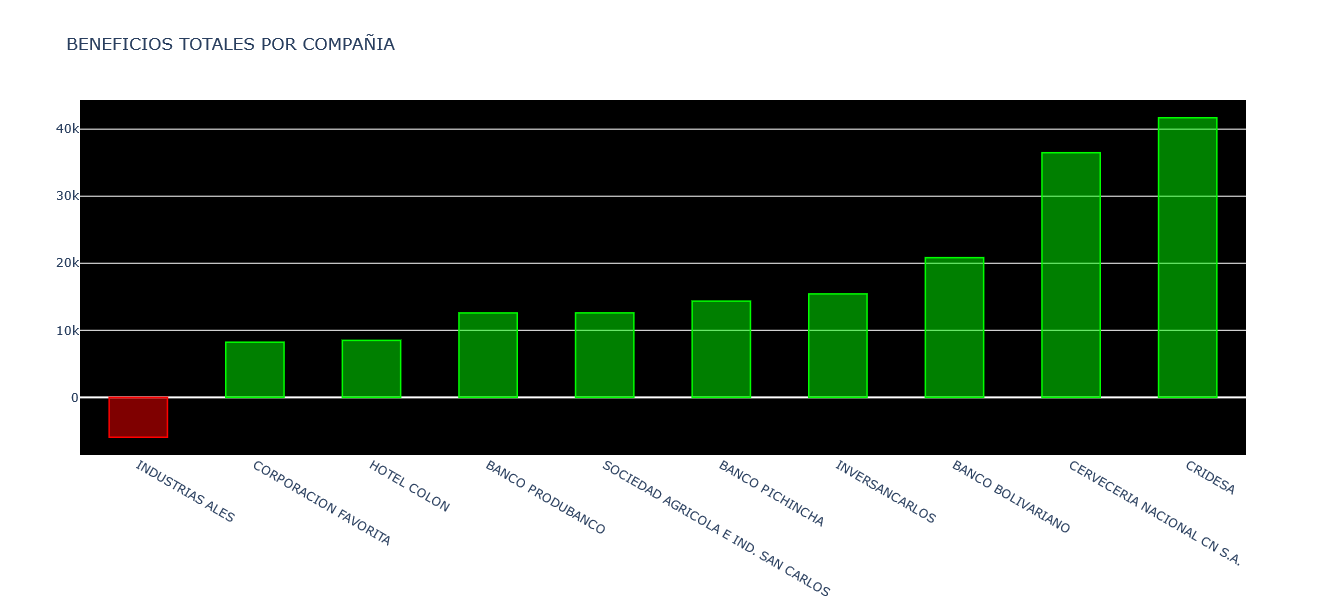

In [26]:
import chart_studio.plotly as py
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

resultados_cias = (reporte.resultados()['TOTAL']-monto_invertido/num_activos).sort_values()

x = resultados_cias.index
y = resultados_cias.values

bins = [-100_000, 0, 100_000]
labels = ['Rojo', 'Verde']

colors = {'Rojo': 'rgba(255, 0, 0, 0.5)',
          'Verde': 'rgba(0, 255, 0, 0.5)'}

df = pd.DataFrame({'y': y,
                   'x': x,
                   'label': pd.cut(y, bins=bins, labels=labels)})

bars = []
for label, label_df in df.groupby('label'):
    bars.append(go.Bar(x=label_df.x,
                       y=label_df.y,
                       name=label,
                       marker={'color': colors[label],}))
    
layout = { "title": "BENEFICIOS TOTALES POR COMPAÑIA", 
          "width": 900, 
          "height": 600,
          "plot_bgcolor": 'rgb (0, 0, 0)'}#None}

fig = go.FigureWidget(data=bars, layout=layout)   
fig.update_layout(showlegend=False)

fig.update_traces( marker_line_color='rgb (0, 255, 0)',
                  marker_line_width=1.5, width=0.5, hovertemplate = '%{y:$.0f}<extra></extra>',
                  selector={'marker_color': 'rgba(0, 255, 0, 0.5)'})

fig.update_traces( marker_line_color='rgb (255, 0, 0)',
                  marker_line_width=1.5, width=0.5, hovertemplate = '%{y:$.0f}<extra></extra>',
                  selector={'marker_color': 'rgba(255, 0, 0, 0.5)'})

iplot(fig)

### Revalorización del precio de la acción VS ingresos por dividendos recibidos

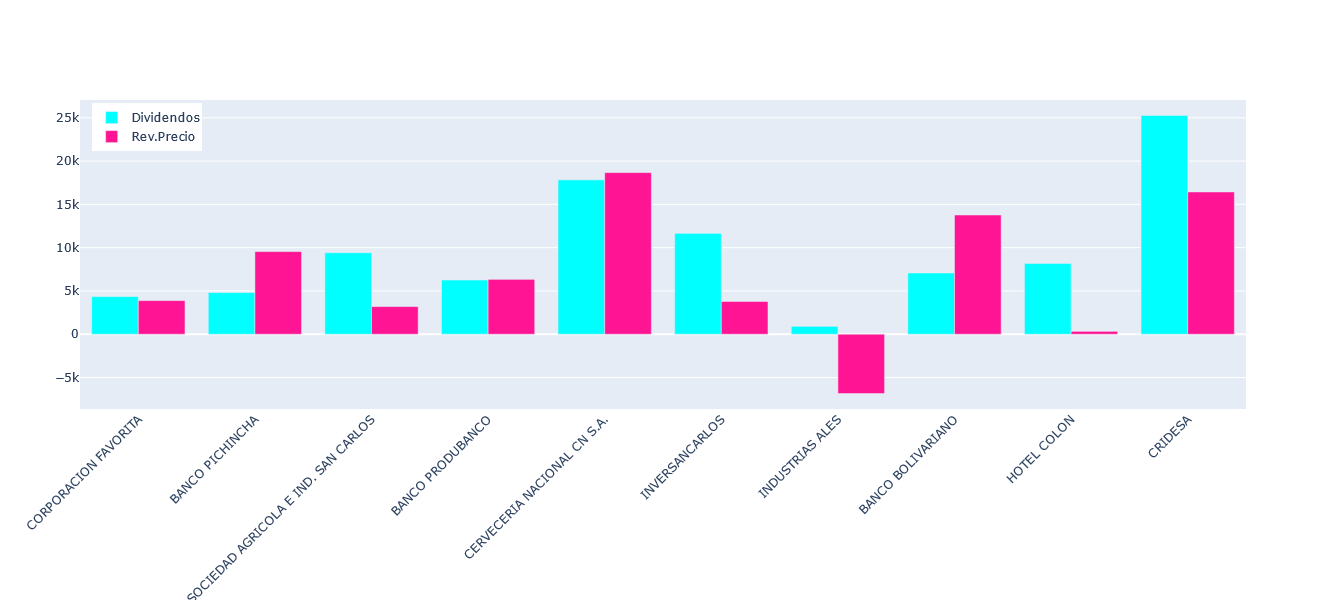

In [27]:
div_vs_precio = reporte.resultados()[['DIVIDENDOS', 'REV. ACCIONES']]
div_vs_precio["REV. ACCIONES"] -= monto_invertido / num_activos

cias = div_vs_precio.index

fig2 = go.Figure()
fig2.add_trace(go.Bar(
    x=cias,
    y=div_vs_precio['DIVIDENDOS'],
    name='Dividendos',
    marker_color='aqua'
))
fig2.add_trace(go.Bar(
    x=cias,
    y=div_vs_precio['REV. ACCIONES'],
    name='Rev.Precio',
    marker_color='deeppink'
))


fig2.update_layout(barmode='group', xaxis_tickangle=-45, height=600, width=920, legend=dict(yanchor="top",
    y=0.99, xanchor="left",x=0.01))
fig2.update_traces( hovertemplate = '%{y:$.0f}<extra></extra>')
fig2.show()

## Comparación con otras alternativas de inversión

Para evaluar mejor el desempeño de las principales acciones de compañias ecuatorianas en la decada pasada, lo debemos hacer comparando con otra/s alternativa/s que hubiesen sido posibles. Como se trata de renta variable las compararemos con los principales indices bursátiles de la bolsa estadounidense.

|      INDICES ACCIONARIOS     | TICKER |
|------------------------------|--------|
| S&P 500                      | ^GSPC  |
| Dow Jones Industrial Average | ^DJI   |
| NASDAQ Composite             | ^IXIC  |
| NASDAQ 100                   | ^NDX   |

In [28]:
import pandas_datareader as pdr

us_indices = ['^GSPC', '^DJI', '^IXIC', '^NDX']
data = pdr.get_data_yahoo(us_indices, start=inicio, end=fin, interval = 'm')['Adj Close']

In [29]:
def balance_cias(seleccion):

    balances = pd.DataFrame()
    lista_flujos = []
    
    for emisor in seleccion:

        df = reporte.balance(emisor)
        df['REINVERSION'] = df['DIVIDENDO'] / df['PRECIO']
        df['TOTAL.ACCIONES'] = df['ACC.POS'] + df['REINVERSION'].cumsum() * df['SPLIT'].cumprod()
        df['BALANCE.AJUST'] = df['PRECIO'] * df['TOTAL.ACCIONES']
        lista_flujos.append(df['BALANCE.AJUST'].rename(emisor))

    return balances.append(lista_flujos).T

In [30]:
import pandas_bokeh
pandas_bokeh.output_notebook()

balances = balance_cias(seleccionadas)
balances_consolidados = pd.DataFrame(balances.ffill().sum(axis=1), columns=['EMP. EC'])
balances_consolidados.index.rename("Date", inplace=True)
indices = pd.merge(balances_consolidados, data, on="Date", how='outer').groupby(pd.Grouper(freq='m')).mean().ffill()
indices.rename(columns={'^GSPC': 'S&P 500','^DJI': 'DOW JONES','^IXIC': 'NASDAQ Composite','^NDX': 'NASDAQ 100'}, inplace=True)

plot=(indices/indices.iloc[0]-1).plot_bokeh(
    kind="line",
    title="Empresas ecuatorianas VS Indices americanos",
    xlabel="Fecha",
    ylabel="Rendimiento",
    yticks=[0, 1, 2, 3, 4],
    ylim=(-0.5, 5),
    colormap=["red", "blue", "green", 'orange', 'cyan'],
    number_format="1%",
    legend = "top_left",
    figsize=(800,480))

Loading BokehJS ...

## Conclusiones

La cartera conformada por las 10 acciones más populares de la década pasada, mostró un desempeño aceptable con un rendimiento final solo un poco por debajo de indices como el Dow Jones y el S&P 500 en el mismo período. También es cierto, que buena parte de la rentabilidad obtenida fue gracias a las dos empresas más rentables que fueron Cervecería Nacional y Cridesa. Aún así considero, una opción atractiva versus la alternativa más utilizada del inversor local, que son los bonos y otros instrumentos de renta fija.

>Las acciones ecuatorianas son particularmente interesantes en cuanto a dividendos incluso por encima de la revalorización de la acción en sí, al contrario de lo que ocurre en acciones de crecimiento en mercados internacionales.
>>La acción más popular **CORPORACION FAVORITA** no es ni de cerca la de mejor desempeño, de hecho se ubicó penúltima con alrededor de un 6% apenas (casi lo mismo que paga un instrumento de renta fija bancario, como los certificados de depósito), lo que demuestra el "mucho ruido y pocas nueces" de esta acción.

Resulta dificil decir el porque de la tan baja participación de los inversores locales en el mercado de renta variable, que es de tan solo 0.3% actualmente y que el resto se lo lleven los títulos de renta fija. Podrian ser muchos los factores que incidan en esta realidad, pero me atrevería a decir que una cultura paupérrima en temas de inversiones bursátiles y un miedo a lo desconocido que crea un sentimiento de que las acciones son algo muy riesgoso en donde se puede perder mucho dinero, todo esto influye de sobremanera. Además de que el propio sistema local se presta y confabula para que la renta fija se venda mucho más que la variable, pues las casas de valores que son las llamadas a asesorar al potencial inversor, que no tiene mucho conocimiento, recomiendan en su gran mayoria y primero a la renta fija antes que la variable. La otra cuestión es que veo a muchas empresas bastantes exitosas financiandose a través de bonos y/o obligaciones en vez de emitir acciones para aquello. De esto se puede hablar muchisimo, pero esta vez solo diré una reflexión final: 
> Si usted quiere rentabilidades importantes en su vida, debe estar consistentemente invertido en renta variable asumiendo el riesgo que con ello conlleva, de lo contrario tendrá que conformarse con rentabilidades que oscilan entre 6% y 8% que ofrece el mercado de renta fija local.